# File and libraries

In [12]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Google Merch Shop"

# DSLabs functions

In [13]:
%run "scripts/dslabs_functions.py"


# Data functions

In [14]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [15]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use sample file when heavy processing
    data=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='returning_user'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18170 entries, 0 to 18169
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_name             18170 non-null  float64
 1   device_language        18170 non-null  float64
 2   geo_region             18170 non-null  float64
 3   geo_city               18170 non-null  float64
 4   traffic_source_medium  18170 non-null  float64
 5   traffic_source_source  18170 non-null  float64
 6   engagement_time_msec   18170 non-null  float64
 7   day_of_year            18170 non-null  float64
 8   page_path_level_1      18170 non-null  float64
 9   path_length            18170 non-null  float64
 10  local_minute_sin       18170 non-null  float64
 11  local_minute_cos       18170 non-null  float64
 12  geo_country            18170 non-null  float64
 13  session_engaged        18170 non-null  float64
 14  is_weekend             18170 non-null  float64
 15  returni

# Distribution Check

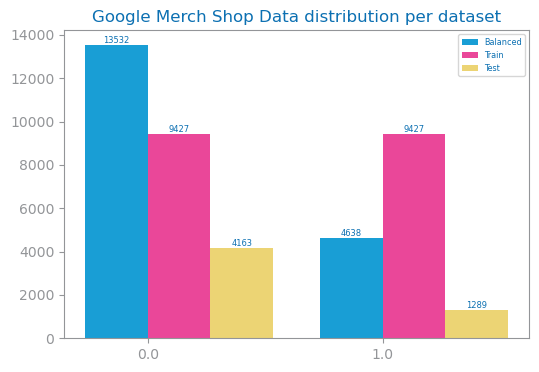

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title=f"{file_tag} Data distribution per dataset")
show()

# evaluate prep

In [6]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=18854 Test#=5452
Labels=[0.0, 1.0]


In [7]:
max_trees_eval=700
max_trees_eval_lag=100

# F2 Evaluate for best model

## f2 study

GB best for 100 trees (d=2 and lr=0.1


<Figure size 640x480 with 0 Axes>

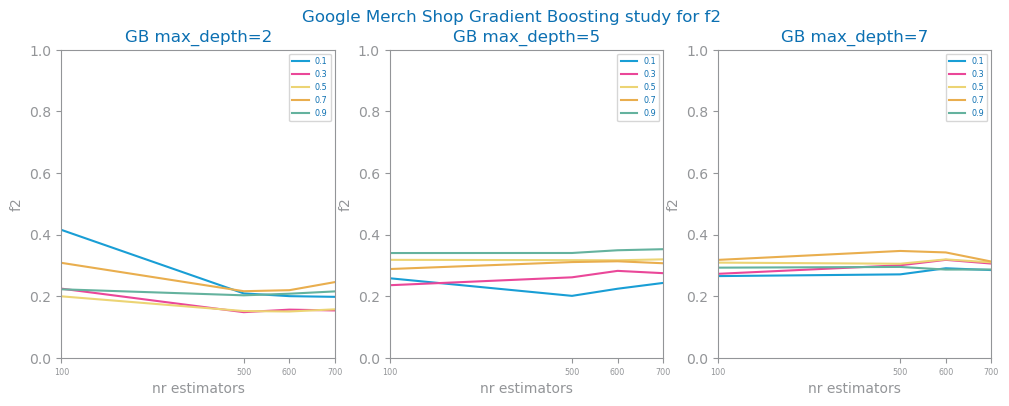

In [68]:
figure()


best_model_f2, f2_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
file_tag=file_tag
)

savefig(f'images/{file_tag}_GB_{f2_params['metric']}_study.png')
show()
    

## f2 Best Model Performance

<Figure size 640x480 with 0 Axes>

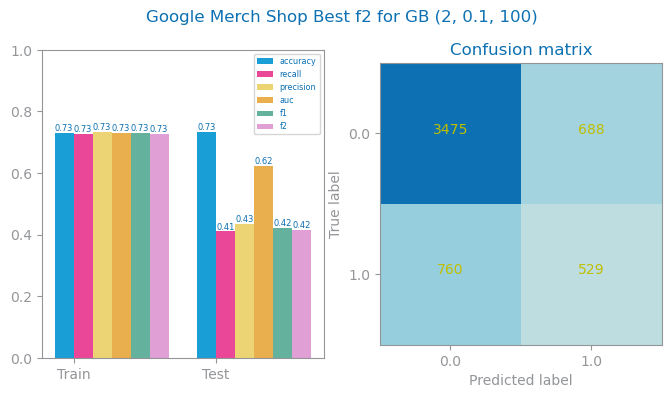

In [69]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_GB_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Variables importance


1. event_name (0.4136098332120834)
2. traffic_source_medium (0.24056136184430163)
3. device_language (0.10235570380533038)
4. traffic_source_source (0.08818192443955072)
5. engagement_time_msec (0.05189832534252652)
6. page_path_level_1 (0.04986289103258728)
7. day_of_year (0.018311746003590923)
8. session_engaged (0.013917118792678764)
9. geo_city (0.009137378233783222)
10. local_minute_cos (0.0051007105779490676)
11. geo_region (0.0047162893656847995)
12. is_weekend (0.0023467173499332433)
13. geo_country (0.0)
14. local_minute_sin (0.0)
15. path_length (0.0)


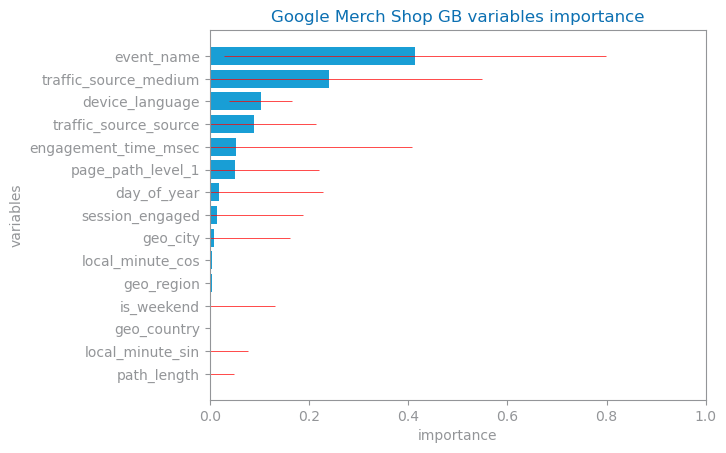

In [70]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_f2.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} GB variables importance for {f2_params["metric"]}",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

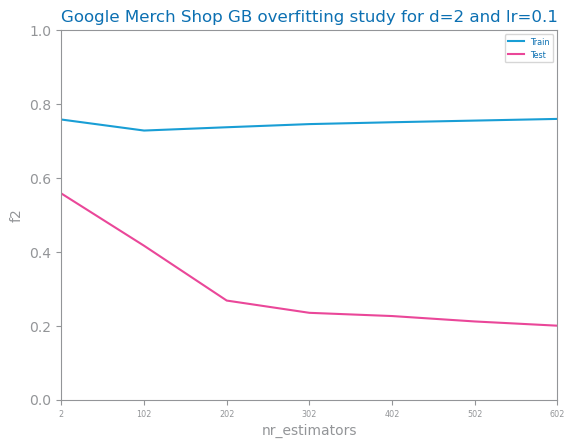

In [71]:

d_max: int = f2_params["params"][0]
lr: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = f2_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Precision Evaluate for best model

## precision study

GB best for 700 trees (d=2 and lr=0.1


<Figure size 640x480 with 0 Axes>

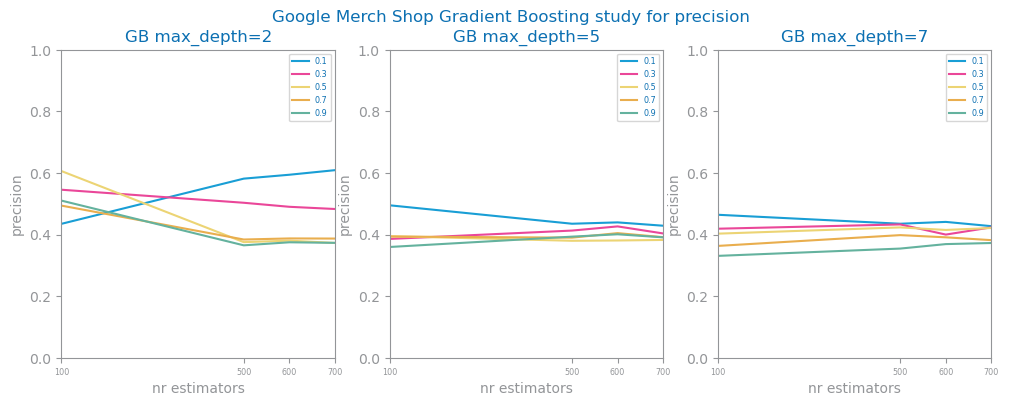

In [16]:
figure()


best_model_prec, prec_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='precision',
file_tag=file_tag

)

savefig(f'images/{file_tag}_GB_{prec_params['metric']}_study.png')
show()

## precision best model performance

<Figure size 640x480 with 0 Axes>

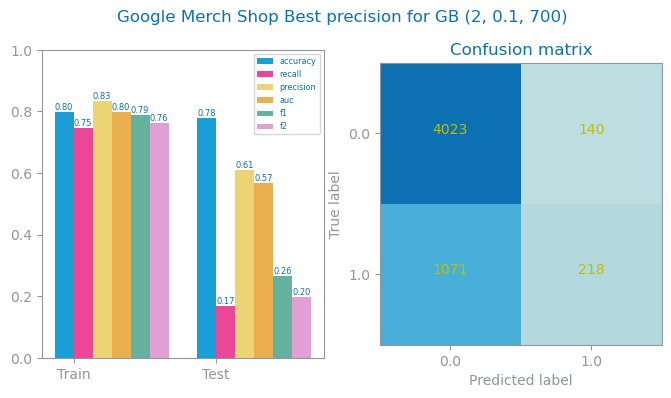

In [20]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_GB_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision Variables importance


In [21]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_prec.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} GB variables importance for {prec_params["metric"]}",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{prec_params["metric"]}_vars_ranking.png")

1. event_name (0.3731058967096822)
2. traffic_source_medium (0.16930313309246034)
3. device_language (0.09262272865970292)
4. local_minute_cos (0.07721296276580038)
5. traffic_source_source (0.06741376761015795)
6. engagement_time_msec (0.051009179355697556)
7. page_path_level_1 (0.04208796645441329)
8. day_of_year (0.035204562410351324)
9. geo_city (0.034479802733515946)
10. local_minute_sin (0.021163718390527553)
11. geo_region (0.01693805865131052)
12. session_engaged (0.010592033760444146)
13. path_length (0.004509390610223225)
14. is_weekend (0.0031154657948408307)
15. geo_country (0.001241333000872147)


IndexError: index 15 is out of bounds for axis 0 with size 15

## precision overfitting

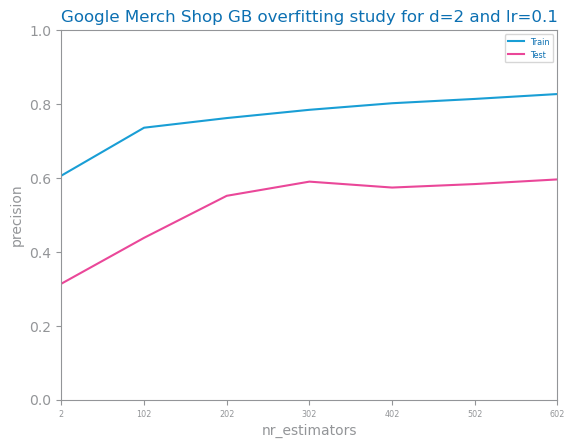

In [22]:

d_max: int = prec_params["params"][0]
lr: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = prec_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
